In [1]:
import sys
sys.path.append('..')
from src.pomdp import *
from src.mdp import VI_Solver

In [2]:
import numpy as np
import random

# POMDP Toy Problem

Symmetric 2 state, 2 action model

## Model definition

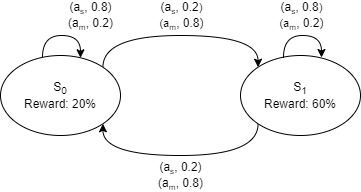

In [3]:
ACTION_COUNT = 2
STATE_COUNT = 2

In [4]:
# 80% chance of success, 10% land in other tile, 10% stay in place
MOVE_RND = 0.8
def transition_function(s, a, s_p):
    s_a = (s + a) % STATE_COUNT
    s_a = s_a if s_a >= 0 else s_a + STATE_COUNT
    
    if s_a == s_p:
        return MOVE_RND
    else:
        return round((1.0 - MOVE_RND) / (STATE_COUNT - 1), 1)

# Setup table to speedup computation
transition_table = np.zeros(shape=(STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for s_p in range(STATE_COUNT):
            transition_table[s,a,s_p] = transition_function(s,a,s_p)

# Test with action 0, ie: LEFT
transition_table[:,0,:]

array([[0.8, 0.2],
       [0.2, 0.8]])

In [5]:
OBS_RND = 0.7 # 70% of observation success
def observation_function(s_p, a, o):
    return OBS_RND if s_p == o else (1.0 - OBS_RND) / (STATE_COUNT - 1)

observation_table = np.zeros((STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s_p in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for o in range(STATE_COUNT):
            observation_table[s_p, a, o] = observation_function(s_p, a, o)
          
observation_table[:,0,:]

array([[0.7, 0.3],
       [0.3, 0.7]])

In [6]:
REWARD_PROBS = [0.2, 0.6]

def reward_function(s, a):
    tot = 0.0
    for s_p in range(STATE_COUNT):
        tot += (REWARD_PROBS[s_p] * transition_table[s,a,s_p])
    return tot

reward_table = np.zeros((STATE_COUNT, ACTION_COUNT))
for s in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        reward_table[s,a] = reward_function(s,a)
        
reward_table

array([[0.28, 0.52],
       [0.52, 0.28]])

In [7]:
states = ['s0','s1']
actions = ['stay', 'move']
observations = ['s0', 's1']

model = POMDP_Model(states, actions, observations, transition_table, reward_table, observation_table)

## Solving

In [8]:
solver = PBVI_Solver(model)

In [9]:
value_function = solver.solve(9,10,eps=0.001)

Converged early...


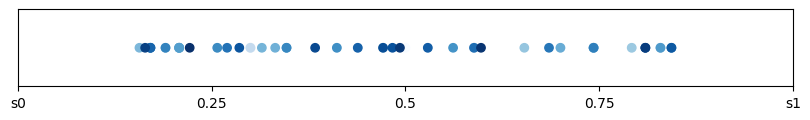

In [10]:
solver.plot_belief_set(10)

In [11]:
value_function

[AlphaVector([4.30458768, 4.54458768]),
 AlphaVector([4.54513673, 4.3038925 ]),
 AlphaVector([4.30394245, 4.54510638]),
 AlphaVector([4.29985179, 4.54664542]),
 AlphaVector([4.54664542, 4.29985179]),
 AlphaVector([4.30007769, 4.54657167]),
 AlphaVector([4.3038925 , 4.54513673]),
 AlphaVector([4.54510638, 4.30394245]),
 AlphaVector([4.54657167, 4.30007769]),
 AlphaVector([4.27924539, 4.55169982]),
 AlphaVector([4.5451048, 4.3039446]),
 AlphaVector([4.54458768, 4.30458768]),
 AlphaVector([4.30390295, 4.54513135]),
 AlphaVector([4.55169982, 4.27924539]),
 AlphaVector([4.57329982, 4.17124539]),
 AlphaVector([4.54513135, 4.30390295]),
 AlphaVector([4.3039446, 4.5451048]),
 AlphaVector([4.17124539, 4.57329982])]

<Figure size 600x400 with 0 Axes>

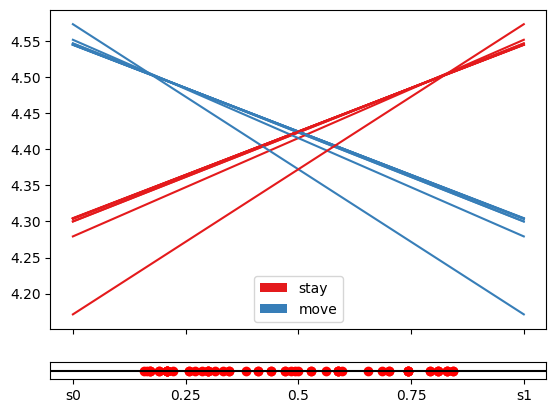

In [12]:
solver.plot_solution(4)

In [13]:
solver.save_history_video()

Video saved at 'Results/s2-a2-ssea-g0.9-e0.001-20230818_203131.mp4'...


## MDP Version of the probelm

In [15]:
vi_solver = VI_Solver(model)

In [16]:
vi_solver.solve()

[AlphaVector([51.6616511, 51.9016511]), AlphaVector([51.9016511, 51.6616511])]

In [16]:
solver.save_history_video(custom_name='comparison-s_2-a_2', compare_with=solver.solution)

[<src.POMDP.pbvi.PBVI object at 0x00000189FF19FFD0>, [AlphaVector([4.25385819, 4.49385819]), AlphaVector([4.49440734, 4.25316288]), AlphaVector([4.25316288, 4.49440734]), AlphaVector([4.49591604, 4.24912213]), AlphaVector([4.49437698, 4.25321284]), AlphaVector([4.24912213, 4.49591604]), AlphaVector([4.22851573, 4.50097044]), AlphaVector([4.50097044, 4.22851573]), AlphaVector([4.25317334, 4.49440195]), AlphaVector([4.49385819, 4.25385819]), AlphaVector([4.12051573, 4.52257044]), AlphaVector([4.25321284, 4.49437698]), AlphaVector([4.49584227, 4.24934807]), AlphaVector([4.52257044, 4.12051573]), AlphaVector([4.49440195, 4.25317334]), AlphaVector([4.24912217, 4.49591602]), AlphaVector([4.24934807, 4.49584227]), AlphaVector([4.4943754 , 4.25321499]), AlphaVector([4.49591602, 4.24912217]), AlphaVector([4.25321499, 4.4943754 ]), AlphaVector([4.25385807, 4.49385828]), AlphaVector([4.49584227, 4.24934807]), AlphaVector([4.24934807, 4.49584227]), AlphaVector([4.49385828, 4.25385807]), AlphaVecto